# Implementing Convolutional Neural Networks in tensorflow and keras

### Objective:

We want to implement a Convolutional Neural Network (CNN) for image recognition. For this we will use two well-known datasets, the first simpler and the second more complicated :

- MNIST (images of digits)
- CIFAR-10 dataset https://www.cs.toronto.edu/~kriz/cifar.html.

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

We will first code the simple ConvNet described below using tensorflow https://www.tensorflow.org environment, then do the same using keras https://keras.io.

- The input of the CNN is a set of (m,n,3) image tensors (m and n depend on the dataset).
- We apply 
    - a Convolutional layer of 32 filters of shape (3,3), with stride (1,1) and padding='same' (i.e. we do not apply zero-padding)
    - additive biases
    - a ReLu activation function
    - a Convolutional layer of 32 filters of shape (3,3), with stride (1,1) and padding='same' (i.e. we do not apply zero-padding)
    - additive biases
    - a ReLu activation function
    - a Max Pooling Layer of shape (2,2) and stride (2,2) (i.e. we reduce by two the size in each dimension)
    - We then Flatten the data (reduce them to a vector in order to be able to apply a Fully-Connected layer to it)
    - A softmax activation function which outputs are the $P(y_c | X)$ (multi-class problem)




# Load packages

In [0]:
%matplotlib inline
%tensorflow_version 1.x
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras.utils.np_utils import to_categorical

## Import data

We first import MNIST dataset.

In [0]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

n_max = 5000
X_train = X_train[0:n_max,:,:]
X_test = X_test[0:n_max,:,:]
y_train = y_train[0:n_max]
y_test = y_test[0:n_max]

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(np.unique(y_train))

(5000, 28, 28)
(5000, 28, 28)
(5000,)
[0 1 2 3 4 5 6 7 8 9]


The mnist dataset has 10 classes. These are the following :

In [0]:
mnist_list = [ '0', '1','2','3','4','5','6','7','8','9']

### Display some of the images

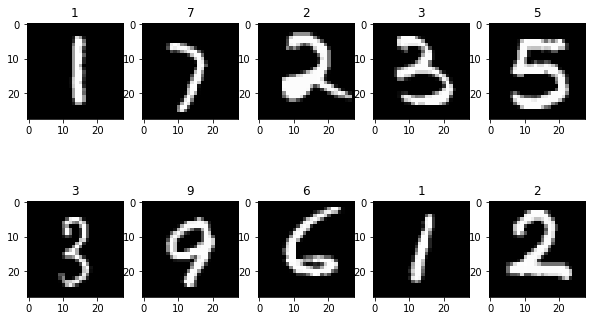

In [0]:
plt.figure(figsize=(10, 6))
for idx in range(0,10):
    plt.subplot(2, 5, idx+1)
    rand_ind = np.random.randint(0,X_test.shape[0])
    plt.imshow(X_test[rand_ind,:,:],cmap='gray')
    plt.title(mnist_list[int(y_test[rand_ind])])

## Format conversion

We now convert the format of the data. In the case of CNNs, and contrary to MLPs, the inputs are not simply vectors of arbitrary size. For example, in the case of images, it is important to distinguish the different dimensions (otherwise the network would not know how to carry out convolutions). Therefore, we need to carry out the following operation :

- reshape the input ```X_train```and ```X_test``` to a set of matrices of size (28,28) and depth 1 (grey-level), convert the data to float32 and normalize them in the range [0,1]. The final dimensions of the image data should be : [batch_size, height, width, n_channels]

Furthermore, as in the previous lab work, we must also convert the label vectors to matrices with k columns, where k is the number of classes. This allows us to carry out the cross-entropy for multi-class problems. Therefore :

- convert the output label ```y_train``` and ```y_test``` to one-hot encoding format.

In [0]:

# input image dimensions (mnist data is grey-level)
img_rows, img_cols, nb_channels = X_train.shape[1], X_train.shape[2], 1

# In case depth is 1 (black and white pictures) -> reshape to proper format
X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, nb_channels)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, nb_channels)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

Y_train = to_categorical(y_train)
Y_test = to_categorical(y_test)

# number of classes
nb_classes = Y_train.shape[1]

print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)
print('There is {} train data'.format(X_train.shape[0]))
print('There is {} test data'.format(X_test.shape[0]))
print(img_rows, img_cols, nb_channels)

X_train shape: (5000, 28, 28, 1)
Y_train shape: (5000, 10)
There is 5000 train data
There is 5000 test data
28 28 1


# 1. CNN with tensorflow

We are now going to create a CNN with Tensorflow, and train it on the previously loaded CIFAR dataset.
- First define the input and output using ```tf.placeholder```
- Define the weights W1,b1,W2,b2 of the CNN using ```tf.get_variable```
    - We initialize them using ```tf.contrib.layers.xavier_initializer```(see https://www.tensorflow.org/api_docs/python/tf/contrib/layers/xavier_initializer)
- Perform the convolution using ```tf.nn.conv2d``` 
- Apply the activation function using ```tf.nn.relu```
- Perform the max pooling using ```tf.nn.max_pool```
- Flatten the output of the convolution using ```tf.contrib.layers.flatten```
- Perform the Fully-Connected part using ```tf.contrib.layers.fully_connected```

Also, note that in Tensorflow, we can carry out the softmax + cross entropy all in one step with the following function :

- ```tf.nn.softmax_cross_entropy_with_logits()```

This has the advantage of being optimised and stabilised by the programmers who wrote Tensorflow, so that we do not have numerical problems.

In [0]:

learning_rate = 0.01
n_epochs = 20
batch_size = 64

# number of convolutional filters to use
nb_filters = 32
# convolution kernel size
kernel_size = (3, 3)
# size of pooling area for max pooling
pool_size = (2, 2)

# --- Size of the successive layers
n_h_0 = nb_channels
n_h_1 = nb_filters
n_h_2 = nb_filters

In [0]:
tf.reset_default_graph()

# input tensor are of shape [batch, in_height, in_width, in_channels]  
# filter / kernel tensor are of shape [filter_height, filter_width, in_channels, out_channels]

X_input = tf.placeholder("float",shape=[None,img_rows,img_cols,nb_channels])
Y_output = tf.placeholder("float",shape=[None,nb_classes])

# use initializer = tf.contrib.layers.xavier_initializer()
W1 = tf.get_variable("W1",shape=[kernel_size[0],kernel_size[1],n_h_0,n_h_1],initializer=tf.contrib.layers.xavier_initializer())
W2 =  tf.get_variable("W2",shape=[kernel_size[0],kernel_size[1],n_h_1,n_h_2],initializer=tf.contrib.layers.xavier_initializer())

# initializer = tf.contrib.layers.xavier_initializer()
b1 =  tf.get_variable("b1",shape=(n_h_1),initializer=tf.contrib.layers.xavier_initializer())
b2 =  tf.get_variable("b2",shape=(n_h_2),initializer=tf.contrib.layers.xavier_initializer())

Z1 = tf.nn.conv2d(X_input,filter=W1,strides=(1,1),padding="SAME") # convolution
A1 = tf.nn.relu(tf.add(Z1,b1)) # bias + relu

Z2 = tf.nn.conv2d(A1,filter=W2,strides=(1,1),padding="SAME") # convolution
A2 = tf.nn.relu(tf.add(Z2,b2)) # bias + relu
P2 = tf.nn.max_pool(A2,ksize=pool_size,strides=(2,2),padding="SAME") # max pool
P3 = tf.contrib.layers.flatten(P2) # flatten
#Hidden1=tf.contrib.layers.fully_connected(inputs=P3,num_outputs=256,activation_fn=tf.nn.relu ,weights_initializer=tf.contrib.layers.xavier_initializer())
#Hidden2=tf.contrib.layers.fully_connected(inputs=Hidden1,num_outputs=256,activation_fn=tf.nn.relu ,weights_initializer=tf.contrib.layers.xavier_initializer())
CNN_output = tf.contrib.layers.fully_connected(inputs=P3,num_outputs=nb_classes,activation_fn=None,weights_initializer=tf.contrib.layers.xavier_initializer())
 # fully connected (note, do not use a non-linearity here, this is done in the next line)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = CNN_output, labels = Y_output))
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)

## Train the model

Cost after epoch 0: 0.862360
Cost after epoch 1: 0.276576
Cost after epoch 2: 0.184683
Cost after epoch 3: 0.156850
Cost after epoch 4: 0.122660
Cost after epoch 5: 0.096531
Cost after epoch 6: 0.074725
Cost after epoch 7: 0.066808
Cost after epoch 8: 0.058116
Cost after epoch 9: 0.070222
Cost after epoch 10: 0.068246
Cost after epoch 11: 0.057021
Cost after epoch 12: 0.051842
Cost after epoch 13: 0.040785
Cost after epoch 14: 0.038237
Cost after epoch 15: 0.037431
Cost after epoch 16: 0.046312
Cost after epoch 17: 0.040053
Cost after epoch 18: 0.042258
Cost after epoch 19: 0.050462


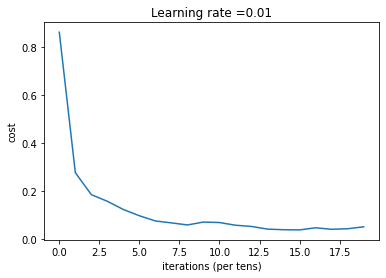

Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 0.985
Test Accuracy: 0.9236
Visual results : 


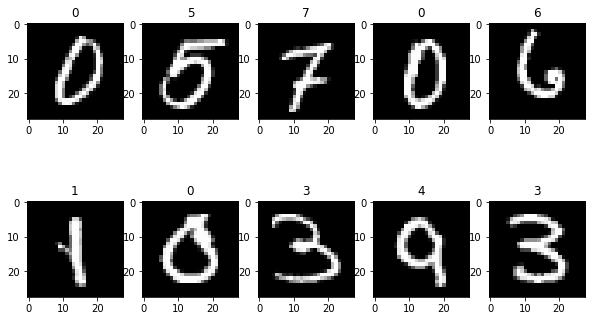

In [0]:
init = tf.global_variables_initializer()
n_batches = int(np.ceil(X_train.shape[0] / float(batch_size)))
costs = []

with tf.Session() as sess:
    sess.run(init)
    
    for epoch in range(n_epochs):
        minibatch_cost = 0.
        for batch_idx in range(n_batches):
            # create batches
            start_idx=batch_idx*batch_size
            end_idx=min((batch_idx+1)*batch_size,X_train.shape[0])
            x_batch=X_train[start_idx:end_idx, :]
            y_batch=Y_train[start_idx:end_idx, :]
   
            # carry out a step of optimisation and calculate the current cost
            _ , temp_cost = sess.run((optimizer,cost),feed_dict={X_input:x_batch,Y_output:y_batch })
            minibatch_cost += temp_cost / n_batches

        if epoch % 1 == 0:
            print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            
        costs.append(minibatch_cost) 
        
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    # Calculate the correct predictions
    predict_op = tf.argmax(CNN_output, 1)
    correct_prediction = tf.equal(predict_op, tf.argmax(Y_output, 1))

    # Calculate accuracy on the test set
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    print(accuracy)
    train_accuracy = accuracy.eval({X_input: X_train, Y_output: Y_train})
    test_accuracy = accuracy.eval({X_input: X_test, Y_output: Y_test})
    print("Train Accuracy:", train_accuracy)
    print("Test Accuracy:", test_accuracy)
  
    print("Visual results : ")
    
    plt.figure(figsize=(10, 6))
    for idx in range(0,10):
        plt.subplot(2, 5, idx+1)
        rand_ind = np.random.randint(0,X_test.shape[0])
        y_classif = sess.run([CNN_output], feed_dict={X_input: np.expand_dims(X_test[rand_ind,:,:,:],axis=0)})

        predicted_class = np.argmax(np.squeeze(y_classif))
        plt.imshow(X_test[rand_ind,:,:].squeeze(),cmap='gray')
        plt.title(mnist_list[int(predicted_class)])
    

## 1.1 Carry out the CNN on CIFAR10

We are now going to train the same network architecture on a more difficult dataset : CIFAR10

First, we import the CIFAR10 data and carry out some pre-processing :

In [0]:
## Import the CIFAR10 data and carry out some pre-processing
from keras.datasets import cifar10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# input image dimensions
img_rows, img_cols, nb_channels = X_train.shape[1], X_train.shape[2], X_train.shape[3]

# In case depth is 1 (black and white pictures) -> reshape to proper format
X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, nb_channels)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, nb_channels)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255.0
X_test /= 255.0

Y_train = to_categorical(y_train)
Y_test = to_categorical(y_test)

nb_classes = Y_train.shape[1]

print('X_train shape:', X_train.shape)
#print('y_train shape:', y_train.shape)
print('Y_train shape:', Y_train.shape)
print('There is {} train data'.format(X_train.shape[0]))
print('There is {} test data'.format(X_test.shape[0]))
print(img_rows, img_cols, nb_channels)


# the CIFAR10 categories
cifar_10_list = [ 'airplane', 'automobile','bird','cat','deer','dog','frog','horse','ship','truck']

#modify the number of input channels 
n_h_0 = nb_channels
# add more epochs
n_epochs = 30


X_train shape: (50000, 32, 32, 3)
Y_train shape: (50000, 10)
There is 50000 train data
There is 10000 test data
32 32 3


Now, we are also going to restrict the data size for computational purposes

In [0]:
max_data = 10000
X_train = X_train[0:max_data,:,:,:]
X_test =  X_test[0:max_data,:,:,:]
Y_train = Y_train[0:max_data,:]
Y_test =  Y_test[0:max_data,:]
print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)


X_train shape: (10000, 32, 32, 3)
Y_train shape: (10000, 10)


### Display some of the images

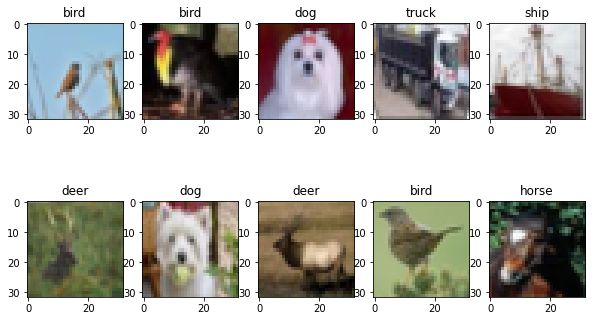

In [0]:
plt.figure(figsize=(10, 6))
for idx in range(0,10):
    plt.subplot(2, 5, idx+1)
    rand_ind = np.random.randint(0,X_test.shape[0])
    plt.imshow(X_test[rand_ind,:,:],cmap='gray')
    plt.title(cifar_10_list[int(y_test[rand_ind])])

## Define the architecture again, for CIFAR10

In this case, we are going to add a layer because the data is more complex. Therefore, we use the following architecture :

    - a Convolutional layer of 32 filters of shape (3,3), with stride (1,1) and padding='same' (i.e. we do not apply zero-padding)
    - additive biases
    - a ReLu activation function
    
    - a Convolutional layer of 32 filters of shape (3,3), with stride (1,1) and padding='same' (i.e. we do not apply zero-padding)
    - additive biases
    - a ReLu activation function
    - a Max Pooling Layer of shape (2,2) and stride (2,2) (i.e. we reduce by two the size in each dimension)
    
    - a Convolutional layer of 32 filters of shape (3,3), with stride (1,1) and padding='same' (i.e. we do not apply zero-padding)
    - additive biases
    - a ReLu activation function
    - a Max Pooling Layer of shape (2,2) and stride (2,2) (i.e. we reduce by two the size in each dimension)
    
    - We then Flatten the data (reduce them to a vector in order to be able to apply a Fully-Connected layer to it)
    - A softmax activation function which outputs are the $P(y_c | X)$ (multi-class problem)

In [0]:

learning_rate = 0.003
n_epochs = 100
batch_size = 256

# number of convolutional filters to use
nb_filters = 32
# convolution kernel size
kernel_size = (3, 3)
# size of pooling area for max pooling
pool_size = (2, 2)


# --- Size of the successive layers
n_h_0 = nb_channels
n_h_1 = nb_filters
n_h_2 = nb_filters
n_h_3 = nb_filters

Cost after epoch 0: 2.110985
Cost after epoch 1: 1.720300
Cost after epoch 2: 1.504092
Cost after epoch 3: 1.383271
Cost after epoch 4: 1.303043
Cost after epoch 5: 1.235527
Cost after epoch 6: 1.166149
Cost after epoch 7: 1.100316
Cost after epoch 8: 1.043422
Cost after epoch 9: 0.987418
Cost after epoch 10: 0.944452
Cost after epoch 11: 0.902427
Cost after epoch 12: 0.874524
Cost after epoch 13: 0.857056
Cost after epoch 14: 0.842296
Cost after epoch 15: 0.809444
Cost after epoch 16: 0.743824
Cost after epoch 17: 0.688963
Cost after epoch 18: 0.651850
Cost after epoch 19: 0.643579
Cost after epoch 20: 0.631693
Cost after epoch 21: 0.629323
Cost after epoch 22: 0.628392
Cost after epoch 23: 0.613389
Cost after epoch 24: 0.591742
Cost after epoch 25: 0.563153
Cost after epoch 26: 0.560798
Cost after epoch 27: 0.538342
Cost after epoch 28: 0.526492
Cost after epoch 29: 0.551684
Cost after epoch 30: 0.556452
Cost after epoch 31: 0.474231
Cost after epoch 32: 0.446539
Cost after epoch 33:

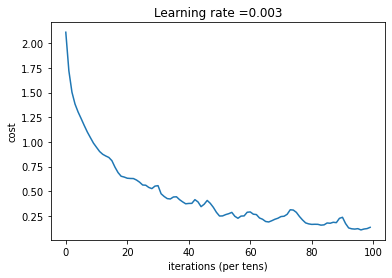

Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 0.9051
Test Accuracy: 0.4797
Visual results : 


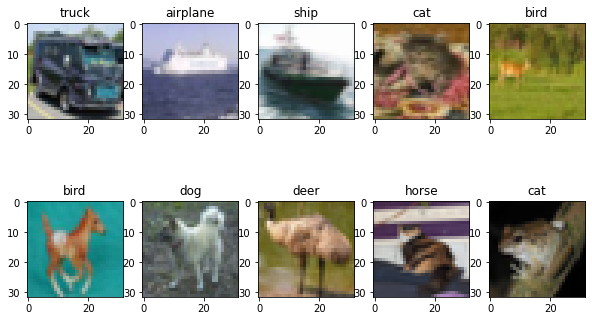

In [0]:
tf.reset_default_graph()

# input tensor are of shape [batch, in_height, in_width, in_channels]  
# filter / kernel tensor are of shape [filter_height, filter_width, in_channels, out_channels]


X_input = tf.placeholder("float",shape=[None,img_rows,img_cols,nb_channels])
Y_output = tf.placeholder("float",shape=[None,nb_classes])

# use initializer = tf.contrib.layers.xavier_initializer()
W1 = tf.get_variable("W1",shape=[kernel_size[0],kernel_size[1],n_h_0,n_h_1],initializer=tf.contrib.layers.xavier_initializer())
W2 =  tf.get_variable("W2",shape=[kernel_size[0],kernel_size[1],n_h_1,n_h_2],initializer=tf.contrib.layers.xavier_initializer())
W3 =  tf.get_variable("W3",shape=[kernel_size[0],kernel_size[1],n_h_2,n_h_3],initializer=tf.contrib.layers.xavier_initializer())

# initializer = tf.contrib.layers.xavier_initializer()
b1 =  tf.get_variable("b1",shape=(n_h_1),initializer=tf.contrib.layers.xavier_initializer())
b2 =  tf.get_variable("b2",shape=(n_h_2),initializer=tf.contrib.layers.xavier_initializer())
b3 =  tf.get_variable("b3",shape=(n_h_3),initializer=tf.contrib.layers.xavier_initializer())

Z1 = tf.nn.conv2d(X_input,filter=W1,strides=(1,1),padding="SAME") # convolution
A1 = tf.nn.relu(tf.add(Z1,b1)) # bias + relu

Z2 = tf.nn.conv2d(A1,filter=W2,strides=(1,1),padding="SAME") # convolution
A2 = tf.nn.relu(tf.add(Z2,b2)) # bias + relu
P2 = tf.nn.max_pool(A2,ksize=pool_size,strides=(2,2),padding="SAME") # max pool

Z3 = tf.nn.conv2d(P2,filter=W3,strides=(1,1),padding="SAME") # convolution
A3 = tf.nn.relu(tf.add(Z3,b3)) # bias + relu
P3 = tf.nn.max_pool(A3,ksize=pool_size,strides=(2,2),padding="SAME") # max pool

F = tf.contrib.layers.flatten(P3) # flatten
#Hidden1=tf.contrib.layers.fully_connected(inputs=F,num_outputs=256,activation_fn=tf.nn.relu ,weights_initializer=tf.contrib.layers.xavier_initializer())
#Hidden2=tf.contrib.layers.fully_connected(inputs=Hidden1,num_outputs=128,activation_fn=tf.nn.relu ,weights_initializer=tf.contrib.layers.xavier_initializer())
CNN_output = tf.contrib.layers.fully_connected(inputs=F,num_outputs=nb_classes,activation_fn=None,weights_initializer=tf.contrib.layers.xavier_initializer())
 # fully connected (note, do not use a non-linearity here, this is done in the next line)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = CNN_output, labels = Y_output))
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)


init = tf.global_variables_initializer()
n_batches = int(np.ceil(X_train.shape[0] / float(batch_size)))
costs = []

with tf.Session() as sess:
    sess.run(init)
    
    for epoch in range(n_epochs):
        minibatch_cost = 0.
        for batch_idx in range(n_batches):
            # create batches
            start_idx=batch_idx*batch_size
            end_idx=min((batch_idx+1)*batch_size,X_train.shape[0])
            x_batch=X_train[start_idx:end_idx, :]
            y_batch=Y_train[start_idx:end_idx, :]
   
            # carry out a step of optimisation and calculate the current cost
            _ , temp_cost = sess.run((optimizer,cost),feed_dict={X_input:x_batch,Y_output:y_batch })
            minibatch_cost += temp_cost / n_batches

        if epoch % 1 == 0:
            print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            
        costs.append(minibatch_cost) 
        
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    # Calculate the correct predictions
    predict_op = tf.argmax(CNN_output, 1)
    correct_prediction = tf.equal(predict_op, tf.argmax(Y_output, 1))

    # Calculate accuracy on the test set
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    print(accuracy)
    train_accuracy = accuracy.eval({X_input: X_train, Y_output: Y_train})
    test_accuracy = accuracy.eval({X_input: X_test, Y_output: Y_test})
    print("Train Accuracy:", train_accuracy)
    print("Test Accuracy:", test_accuracy)
  
    print("Visual results : ")
    
    plt.figure(figsize=(10, 6))
    for idx in range(0,10):
        plt.subplot(2, 5, idx+1)
        rand_ind = np.random.randint(0,X_test.shape[0])
        y_classif = sess.run([CNN_output], feed_dict={X_input: np.expand_dims(X_test[rand_ind,:,:,:],axis=0)})

        predicted_class = np.argmax(np.squeeze(y_classif))
        plt.imshow(X_test[rand_ind,:,:].squeeze(),cmap='gray')
        plt.title(cifar_10_list[int(predicted_class)])
    


$\implies$ The results with the CIFAR-10 Dataset is worse than the results of MINST, using as a criteria  the Test accuracy ( MINST 0.94  vs 0.44 CIFAR-10 ) and that is due to the diffrence between the datasets, CIFAR-10 is more complexe than minst data and also MINST data  have grayscale values but CIFAR are color images.

We can solve this issue by make the NN more complexe (aka adding more  hidden layers) and/or training the model longer and/or changing the learning rate.